In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from datetime import datetime
import plotly.express as px

# Für die Modellierung
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

###############################################################################
# 0) Daten laden
###############################################################################

DATA_PATH = "feinstaubdataexercise.pickle"

with open(DATA_PATH, 'rb') as file:
    dailymeansdata = pkl.load(file)

# Dictionary Keys: 'Graz-DB' und 'Kalkleiten'
df_graz = dailymeansdata["Graz-DB"].copy()   # Das DataFrame, auf das wir uns konzentrieren
df_kalk = dailymeansdata["Kalkleiten"].copy()  # Für spätere Inversions-Variable (temp-Diff)

# Index ist DateTime mit TimeZone, optional kann man die Zeitzone droppen oder konvertieren
df_graz.index = df_graz.index.tz_localize(None)
df_kalk.index = df_kalk.index.tz_localize(None)

# Ein kurzer Blick auf die Daten
print("---- Info Graz-DB ----")
df_graz.info()
print(df_graz.head())

print("\n---- Info Kalkleiten ----")
df_kalk.info()
print(df_kalk.head())

# Scheinbar gibt es ein paar null-Werte in no2 und pm10
# Für Kalkleiten gibt es scheinbar nur die Temperaturen auch hier finden wir einige null-Werte. (siehe PUnkt 1b)

---- Info Graz-DB ----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2015-01-01 to 2020-12-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   day_type       2161 non-null   category
 1   humidity       2161 non-null   float64 
 2   temp           2161 non-null   float64 
 3   no2            2157 non-null   float64 
 4   pm10           2146 non-null   float64 
 5   prec           2161 non-null   float64 
 6   windspeed      2161 non-null   float64 
 7   peak_velocity  2161 non-null   float64 
dtypes: category(1), float64(7)
memory usage: 137.2 KB
                  day_type   humidity      temp        no2        pm10  \
DateTime                                                                 
2015-01-01  Sunday/Holiday  76.086280 -3.114223  55.883530  113.757540   
2015-01-02         Weekday  84.450230  0.345273  82.513820   94.340850   
2015-01-03        Saturday  89.667440  1.184227  65.

In [2]:
###############################################################################
# 1) Erste Exploration: Zusammenhänge, Verteilung, Missing Data
###############################################################################

# a) In welchen Bereichen bewegen sich die Variablen?
desc = df_graz.describe()
print("\n--- DESCRIBE (Graz-DB) ---")
print(desc)


--- DESCRIBE (Graz-DB) ---
          humidity         temp          no2         pm10         prec  \
count  2161.000000  2161.000000  2157.000000  2146.000000  2161.000000   
mean     72.880523    11.567293    40.597098    27.435716     1.813781   
std      12.893109     8.289439    14.191078    15.822951     5.069202   
min      37.992634   -10.208468     8.024886     2.248819     0.000000   
25%      63.312733     4.660096    30.276724    16.907141     0.000000   
50%      72.677450    11.861993    38.872180    23.465809     0.000000   
75%      83.259100    18.658024    48.544228    33.629410     0.700892   
max      97.546480    28.999367   104.850220   153.803670    69.523677   

         windspeed  peak_velocity  
count  2161.000000    2161.000000  
mean      0.618586       5.935617  
std       0.351442       3.320835  
min       0.114222       1.322557  
25%       0.404981       3.350479  
50%       0.534850       5.025719  
75%       0.715614       7.847174  
max       3.00058

In [3]:
# b) Missing Data Visualisierung
# Wir sehen bereits in df_graz.info(), dass no2 und pm10 Lücken haben.
# Hier noch eine genauere Aufstellung wo:
print("\n--- Missing Values Graz ---")
print(df_graz.isnull().sum())

print("\n--- Missing Values Kalkleiten ---")
print(df_kalk.isnull().sum())


--- Missing Values Graz ---
day_type          0
humidity          0
temp              0
no2               4
pm10             15
prec              0
windspeed         0
peak_velocity     0
dtype: int64

--- Missing Values Kalkleiten ---
day_type     0
temp        21
dtype: int64


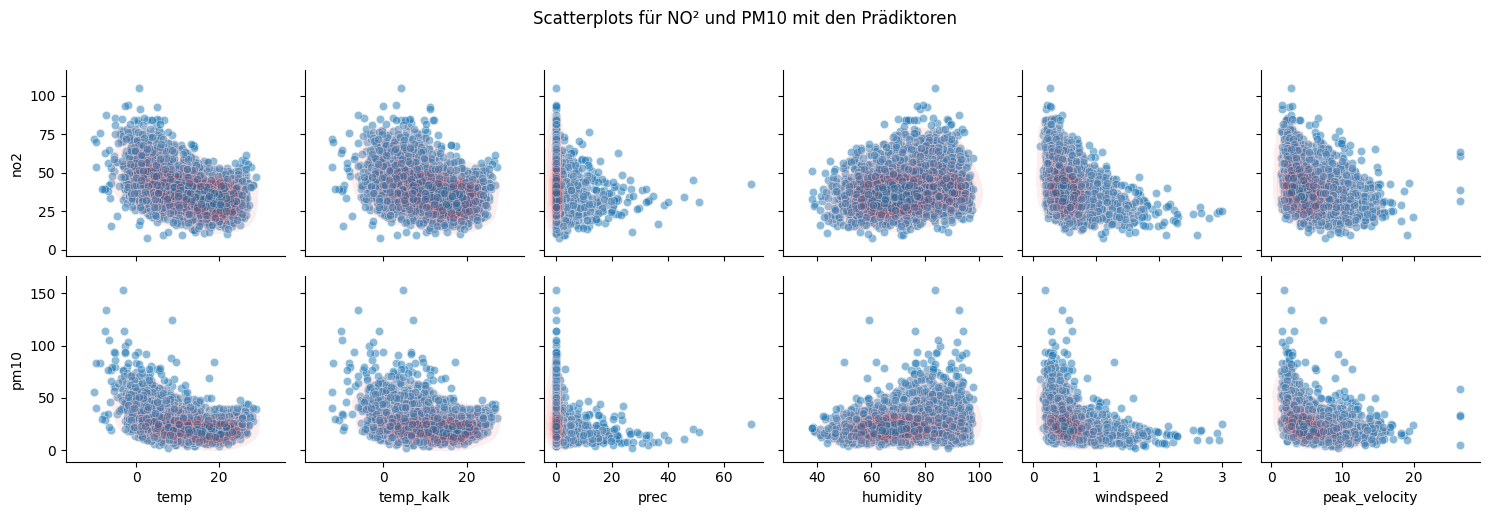

In [4]:
# c) Paarweise Scatterplots, um einen Eindruck der Zusammenhänge zu gewinnen
#   (ohne day_type, da kategorisch)
# Temperaturdaten von Kalkleiten hinzufügen
df_combined = pd.merge(
    df_graz,
    df_kalk[["temp"]].rename(columns={"temp": "temp_kalk"}),
    left_index=True,
    right_index=True,
    how="inner"
)

# Fokus-Spalten: NO₂ und PM10 als Zielvariablen, Prädiktoren als X-Achsen
cols_focus = ["no2", "pm10", "temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"]

# Daten für die Visualisierung extrahieren
df_focus = df_combined[cols_focus]

# PairGrid: Nur Scatterplots für NO₂ und PM10 mit Prädiktoren
g = sns.PairGrid(df_focus, y_vars=["no2", "pm10"], x_vars=["temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"])
g.map(sns.scatterplot, alpha=0.5)  # Scatterplot
g.map(sns.kdeplot, color="red", fill=True, alpha=0.2)  # Dichtekurven

# Titel und Layout anpassen
g.fig.suptitle("Scatterplots für NO² und PM10 mit den Prädiktoren", y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)  # Platz für den Titel

# Plot speichern und anzeigen
plt.savefig("scatter_no2_pm10_prädiktoren.png")
plt.show()

# Interessant erscheinen hier vorallem folgende Zusammenhänge:
# 1) NO² und pm10 mit Temperatur (nicht linear)
# 2) NO² mit pm10 (linear) soll aber nicht in betracht gezogen werden.
# 3) pm10 und prec (Niederschlag in l/m²), könnte auf eine hyperbolische Beziehung hindeuten
# 4) windspeed und pm10 scheinen negativ zu korrelieren.


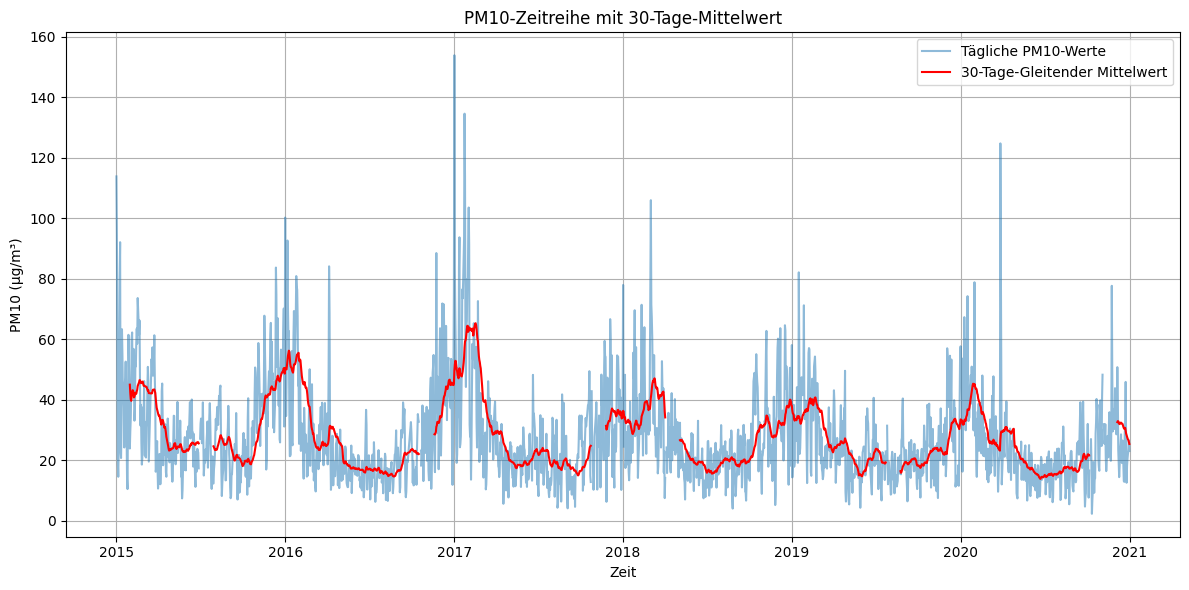

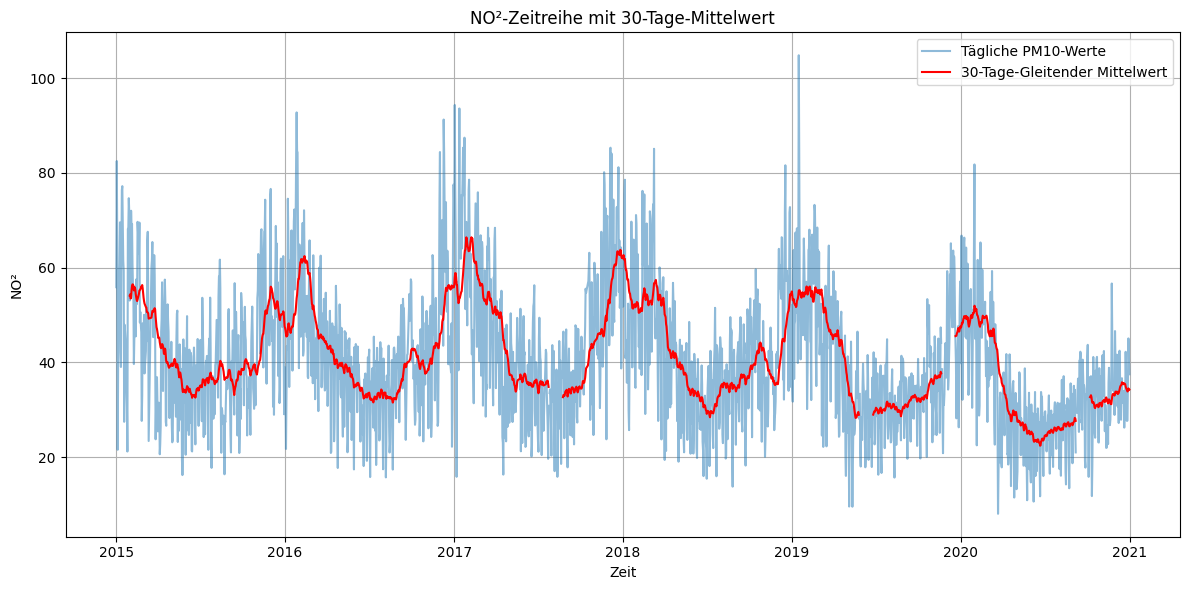

In [5]:
# Plotten von Feinstaub und NO² über die Zeit um Muster/Trends zu erkennen:
# Gleitender Durchschnitt
df_graz["pm10_rolling"] = df_graz["pm10"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["pm10"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["pm10_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("PM10 (µg/m³)")
plt.title("PM10-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

df_graz["no2_rolling"] = df_graz["no2"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["no2"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["no2_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("NO²")
plt.title("NO²-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Deutlich wird hier ein Phasischer Verlauf vermutlich korrelierend mit den Wintermonaten (Heiz Saison, mehr Autoverkehr etc.)
# Zu diesem Zweck verwenden wir eine Heatmap um diese Vermutung zu Untersuchen.

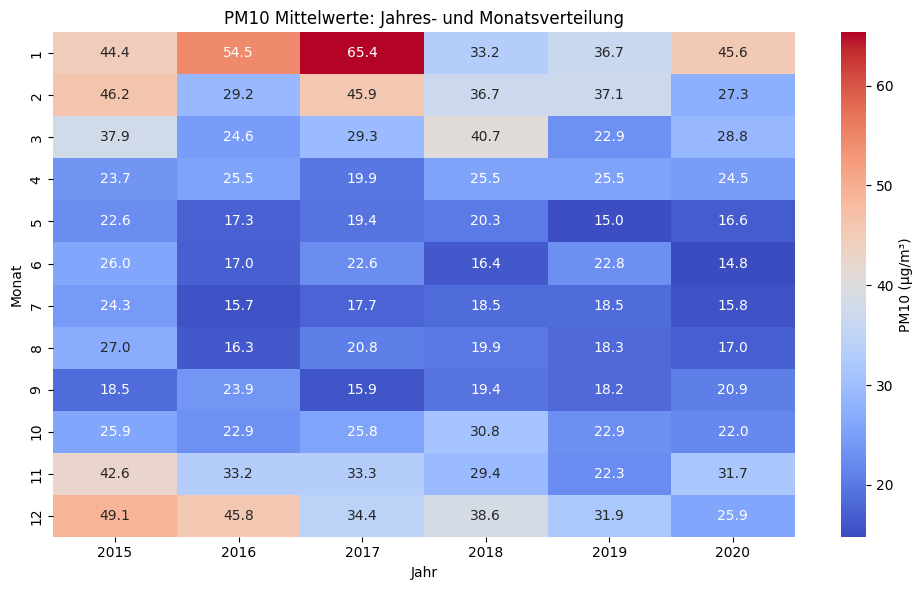

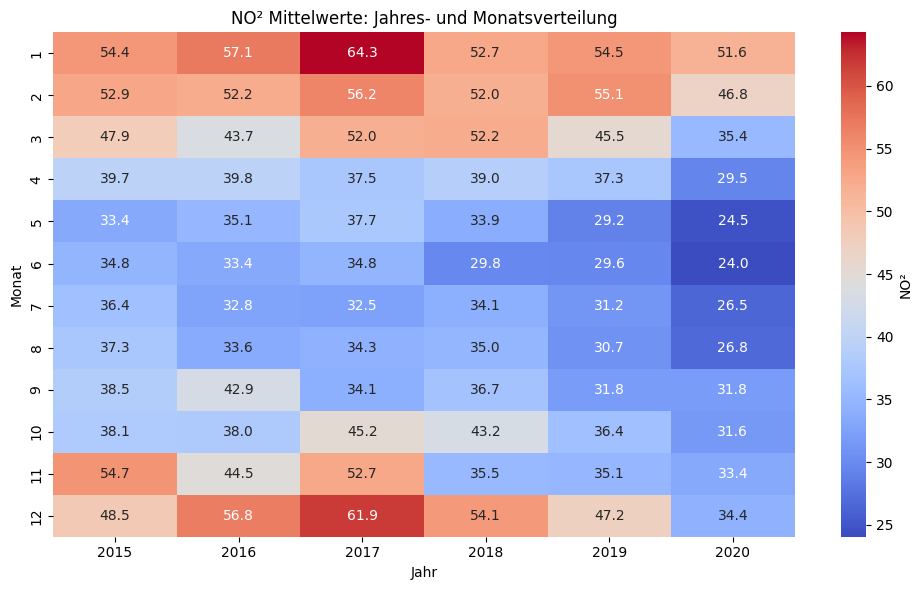

In [6]:
# Monat und Jahr aus dem Index extrahieren
df_graz["year"] = df_graz.index.year
df_graz["month"] = df_graz.index.month

# Pivot-Tabelle erstellen
heatmap_data = df_graz.pivot_table(
    values="pm10", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "PM10 (µg/m³)"})
plt.title("PM10 Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

heatmap_data = df_graz.pivot_table(
    values="no2", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "NO²"})
plt.title("NO² Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

# Es ist eindeutig ersichtlich, dass um die Wintermonate (11. - 2.) Die Belastung am höchsten ist.

In [7]:
###############################################################################
# 2) Erstes Modell für pm10 und no2 (2015-2019) - Lineare Regression
###############################################################################

# a) Train/Test Split: 2015-2019 Trainingsdaten, 2020 Testdaten
#   Wir filtern nach Jahr
train_df = df_graz.loc[(df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)].copy()
test_df = df_graz.loc[(df_graz.index.year == 2020)].copy()

# b) Wir lassen no2 NICHT als Prädiktor in pm10-Modell zu und umgekehrt
#   => Prädiktoren: day_type, humidity, temp, prec, windspeed, peak_velocity
#   (pm10 oder no2 jeweils ausgeschlossen)

regression_modell = smf.ols("pm10 ~ temp + windspeed + prec", data=train_df).fit()
regression_modell.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm10   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     308.0
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          4.81e-161
Time:                        11:50:46   Log-Likelihood:                -7125.2
No. Observations:                1784   AIC:                         1.426e+04
Df Residuals:                    1780   BIC:                         1.428e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1739      0.706     65.387      0.000      44.789      47.559
temp          -0.7998      0.038    -20.920      0.000      -0.875      -0.725
windspeed    -12.8252      0.897    -14.302      0.000     -14.584     -11.066
prec          -0.4739      0.060     -7.876      0.000      -0.592      -0.356
==============================================================================
Omnibus:                      608.650   Durbin-Watson:                   0.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3150.793
Skew:                           1.521   Prob(JB):                         0.00
Kurtosis:                       8.756   Cond. No.                         48.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# c) Modell für pm10
#   Simple OLS in statsmodels, wir schließen no2 aus dem Modell aus.
pm10_train = train_df.dropna(subset=["pm10"])  # Zeilen ohne pm10 weg
predictors_pm10 = ["humidity", "temp", "prec", "windspeed", "peak_velocity"]

formula_pm10 = "pm10 ~ " + " + ".join(predictors_pm10)
model_pm10 = ols(formula_pm10, data=pm10_train).fit()
print("\n--- Modell PM10: OLS Summary ---")
print(model_pm10.summary())

# ANOVA
anova_pm10 = sm.stats.anova_lm(model_pm10, typ=2)
print("\n--- ANOVA PM10 ---")
print(anova_pm10)



--- Modell PM10: OLS Summary ---
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     186.2
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          9.92e-160
Time:                        11:50:46   Log-Likelihood:                -7122.4
No. Observations:                1784   AIC:                         1.426e+04
Df Residuals:                    1778   BIC:                         1.429e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept   

In [9]:
###############################################################################
# 3) Erstes Modell für pm10 und no2 (2015-2019) - Lineare Regression
###############################################################################

# a) Trainings- und Test-Zeitraum definieren
train_df = df_graz.loc[(df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)].copy()
test_df  = df_graz.loc[df_graz.index.year == 2020].copy()

# b) Zeilen ohne PM10 oder temp_diff entfernen
train_pm10 = train_df.dropna(subset=['pm10','temp_diff'])

# c) Prädiktoren
predictors = ['humidity', 'temp', 'prec', 'windspeed', 'peak_velocity', 'temp_diff']
formula = "pm10 ~ " + " + ".join(predictors)

# d) Modell schätzen
model_pm10_inversion = ols(formula, data=train_pm10).fit()

# e) Ergebnisse ansehen
print(model_pm10_inversion.summary())

KeyError: ['temp_diff']

In [19]:
#Punkt 4: Mostafa
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm

def create_enhanced_features(df_graz, df_kalk):
    """Create enhanced features based on the air pollution data characteristics"""
    
    # Basic binary indicators
    df = df_graz.copy()
    df['frost'] = (df['temp'] < 0).astype(int)  # Clear frost days from temp data
    df['temp_diff'] = df['temp'] - df_kalk['temp']  # Temperature difference
    df['inversion'] = (df['temp_diff'] < 0).astype(int)  # Temperature inversion
    
    # Wind-related features (based on distribution in data)
    df['strong_wind'] = (df['windspeed'] > df['windspeed'].mean() + df['windspeed'].std()).astype(int)
    df['calm_conditions'] = (df['windspeed'] < df['windspeed'].quantile(0.25)).astype(int)
    
    # Temporal features
    df['month'] = df.index.month
    df['winter'] = df['month'].isin([12, 1, 2]).astype(int)
    
    # Lagged variables (shown important in time series)
    for col in ['temp', 'humidity', 'windspeed', 'prec']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)
    
    # Rolling means (3-day window based on visible patterns)
    for col in ['temp', 'humidity', 'windspeed']:
        df[f'{col}_3day_mean'] = df[col].rolling(window=3).mean()
    
    # Interaction terms
    df['frost_calm'] = df['frost'] * df['calm_conditions']
    df['inversion_winter'] = df['inversion'] * df['winter']
    
    # Extreme condition indicators
    df['high_humidity'] = (df['humidity'] > df['humidity'].quantile(0.75)).astype(int)
    df['low_windspeed_high_humidity'] = (df['calm_conditions'] * df['high_humidity'])
    
    return df

def compare_pollution_models(df, target, basic_vars, enhanced_vars):
    """Compare basic and enhanced models for pollution prediction"""
    
    # Prepare training data (2015-2019)
    train_mask = (df.index.year >= 2015) & (df.index.year <= 2019)
    train_df = df[train_mask].copy()
    
    # Basic model
    basic_formula = f"{target} ~ " + " + ".join(basic_vars)
    basic_model = ols(basic_formula, data=train_df.dropna()).fit()
    
    # Enhanced model
    enhanced_formula = f"{target} ~ " + " + ".join(enhanced_vars)
    enhanced_model = ols(enhanced_formula, data=train_df.dropna()).fit()
    
    return basic_model, enhanced_model

# Define variable sets
basic_vars = ['temp', 'humidity', 'prec', 'windspeed', 'peak_velocity']
enhanced_vars = basic_vars + [
    'frost', 'inversion', 'strong_wind', 'calm_conditions',
    'winter', 'temp_lag1', 'humidity_lag1', 'windspeed_lag1',
    'temp_3day_mean', 'frost_calm', 'inversion_winter',
    'low_windspeed_high_humidity'
]

# Create enhanced features
df_enhanced = create_enhanced_features(df_graz, df_kalk)

# Compare models for PM10
pm10_basic, pm10_enhanced = compare_pollution_models(df_enhanced, 'pm10', basic_vars, enhanced_vars)

# Compare models for NO2
no2_basic, no2_enhanced = compare_pollution_models(df_enhanced, 'no2', basic_vars, enhanced_vars)

# Print results
print("=== PM10 Model Comparison ===")
print(f"Basic R-squared: {pm10_basic.rsquared:.3f}")
print(f"Enhanced R-squared: {pm10_enhanced.rsquared:.3f}")
print("\nSignificant new predictors (p < 0.05):")
for var in enhanced_vars:
    if var not in basic_vars:
        pval = pm10_enhanced.pvalues.get(var)
        if pval is not None and pval < 0.05:
            coef = pm10_enhanced.params.get(var)
            print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

print("\n=== NO2 Model Comparison ===")
print(f"Basic R-squared: {no2_basic.rsquared:.3f}")
print(f"Enhanced R-squared: {no2_enhanced.rsquared:.3f}")
print("\nSignificant new predictors (p < 0.05):")
for var in enhanced_vars:
    if var not in basic_vars:
        pval = no2_enhanced.pvalues.get(var)
        if pval is not None and pval < 0.05:
            coef = no2_enhanced.params.get(var)
            print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

=== PM10 Model Comparison ===
Basic R-squared: 0.356
Enhanced R-squared: 0.522

Significant new predictors (p < 0.05):
frost: coef=14.7110, p=0.0000
inversion: coef=7.7781, p=0.0000
humidity_lag1: coef=-0.2188, p=0.0000
windspeed_lag1: coef=-5.6411, p=0.0000
temp_3day_mean: coef=-2.1843, p=0.0000

=== NO2 Model Comparison ===
Basic R-squared: 0.405
Enhanced R-squared: 0.549

Significant new predictors (p < 0.05):
inversion: coef=8.4323, p=0.0000
winter: coef=4.9318, p=0.0000
humidity_lag1: coef=-0.2246, p=0.0000
windspeed_lag1: coef=-2.9026, p=0.0022
temp_3day_mean: coef=-1.3682, p=0.0006
frost_calm: coef=6.9222, p=0.0001
low_windspeed_high_humidity: coef=-5.2352, p=0.0000


=== PM10 Modellvergleich ===
R² Original: 0.344
R² Wurzeltransformation: 0.366
AIC Original: 14256.9
AIC Wurzeltransformation: 5447.6

=== NO2 Modellvergleich ===
R² Original: 0.411
R² Wurzeltransformation: 0.412
AIC Original: 13652.8
AIC Wurzeltransformation: 4417.1


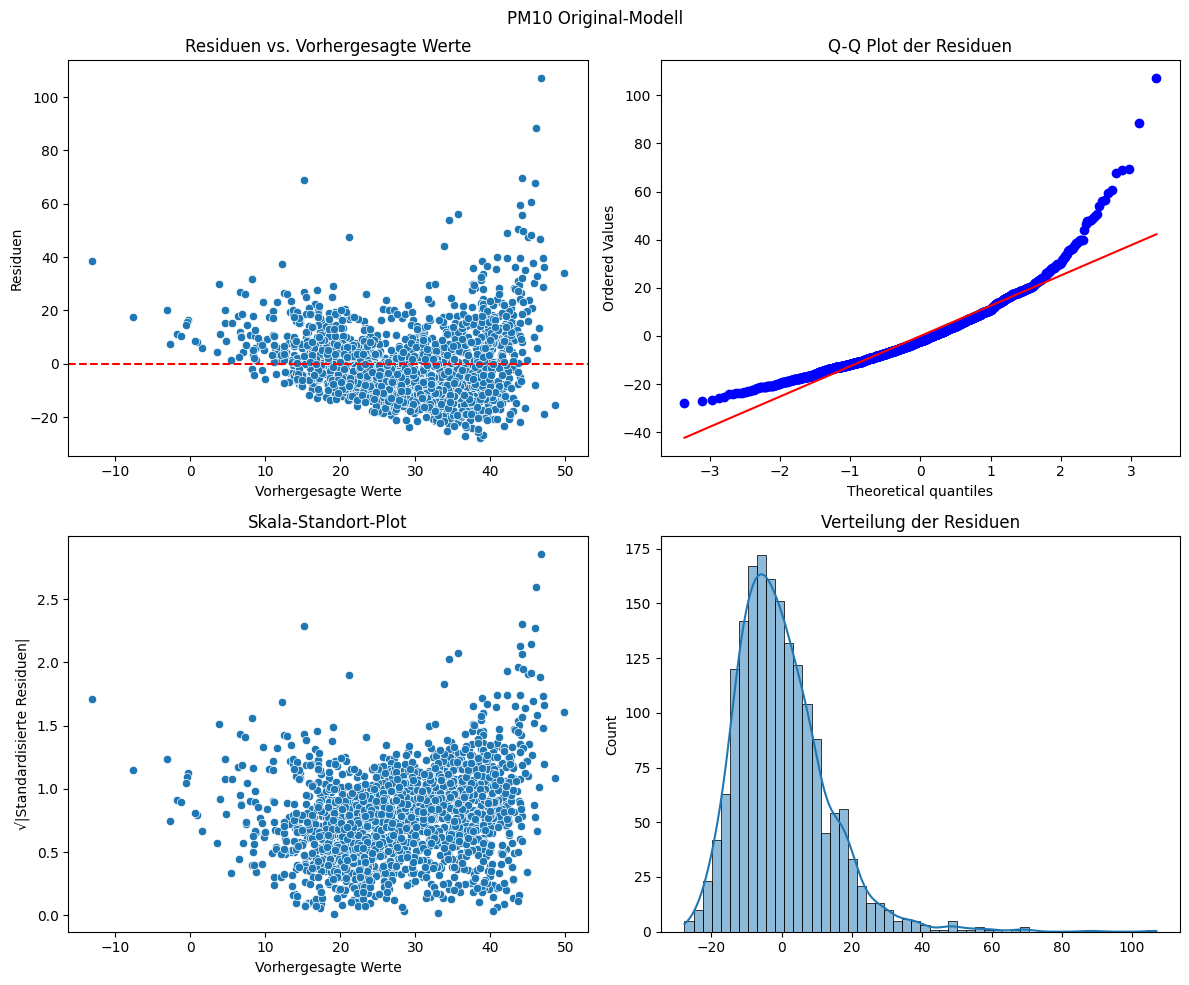

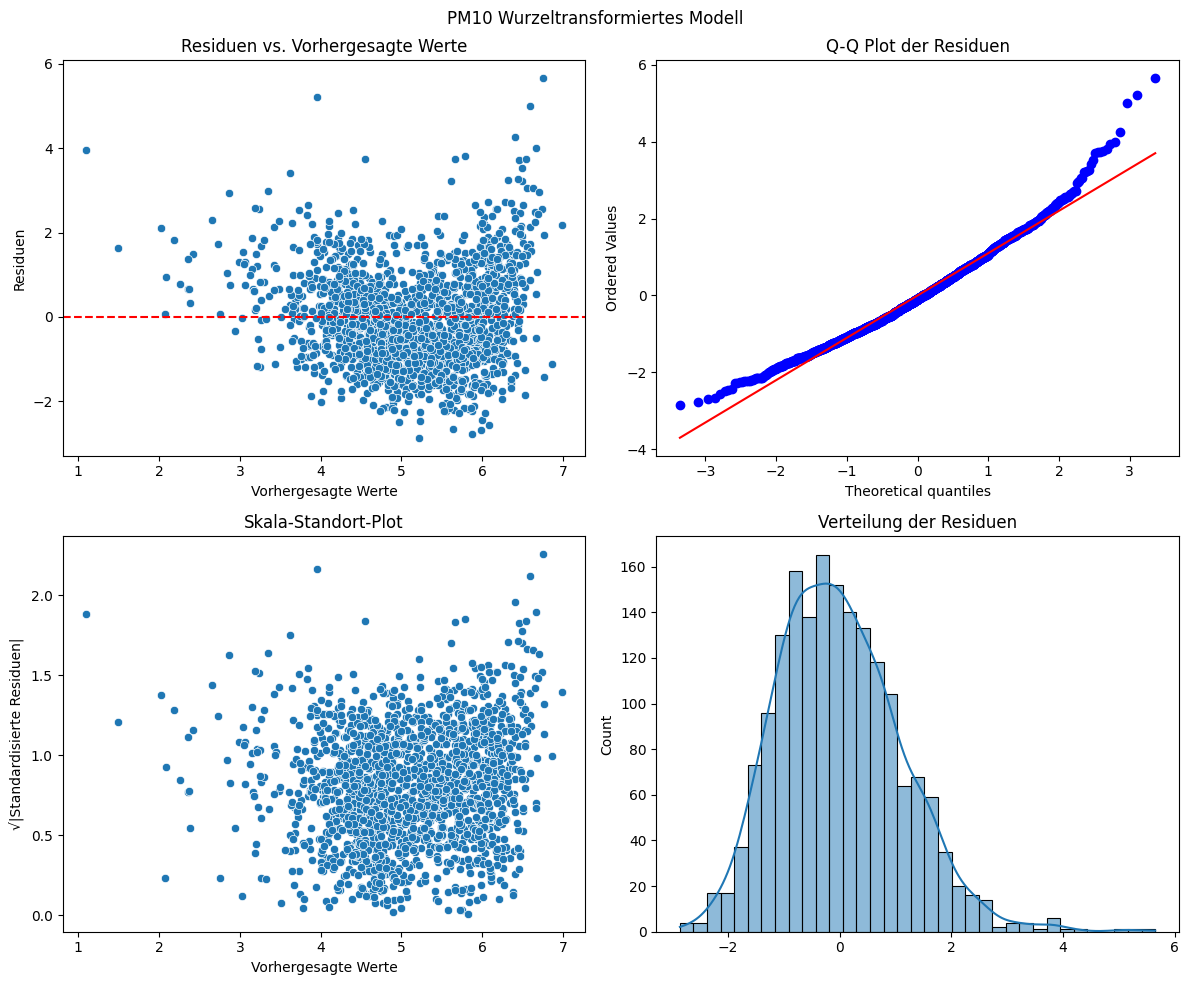

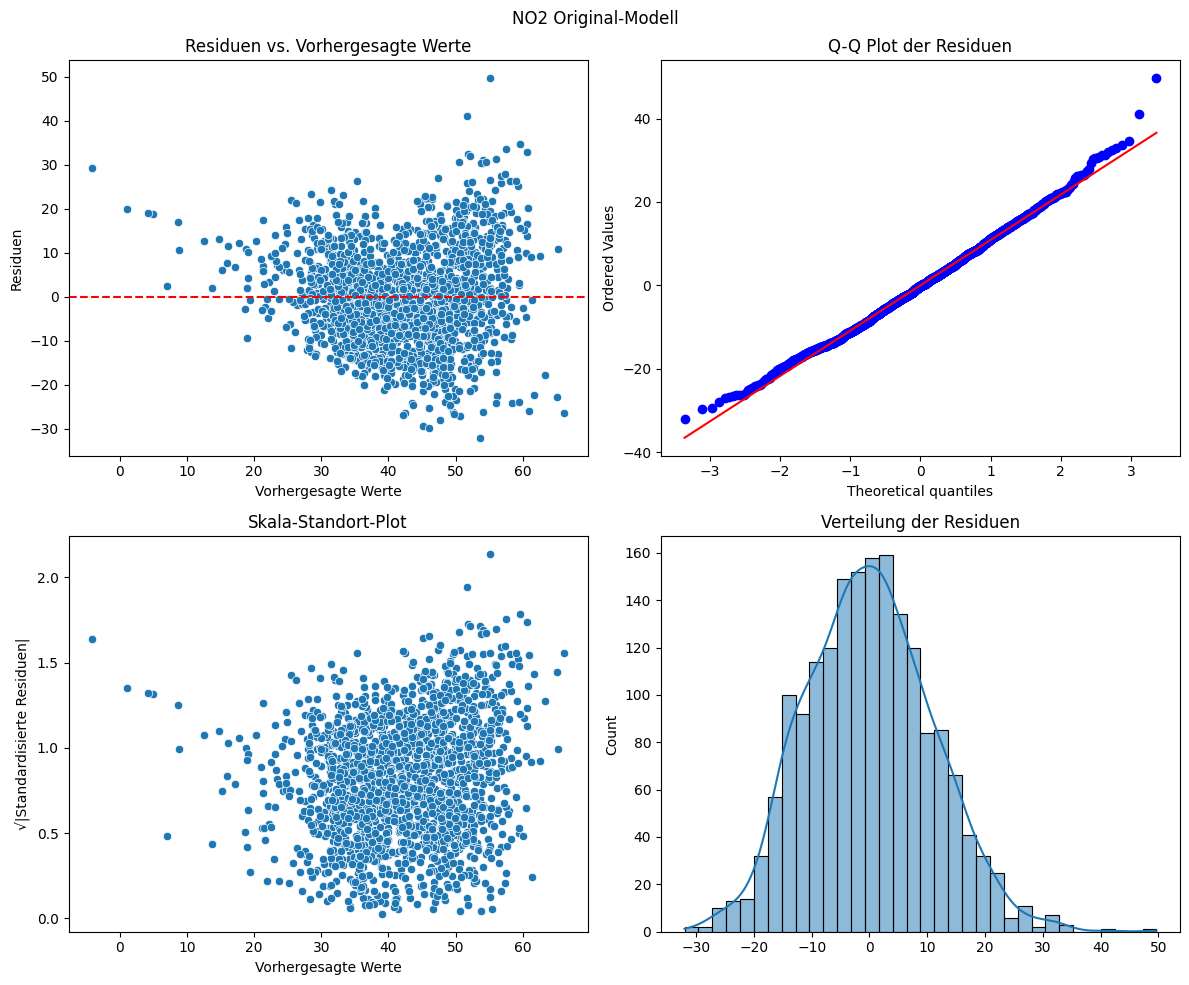

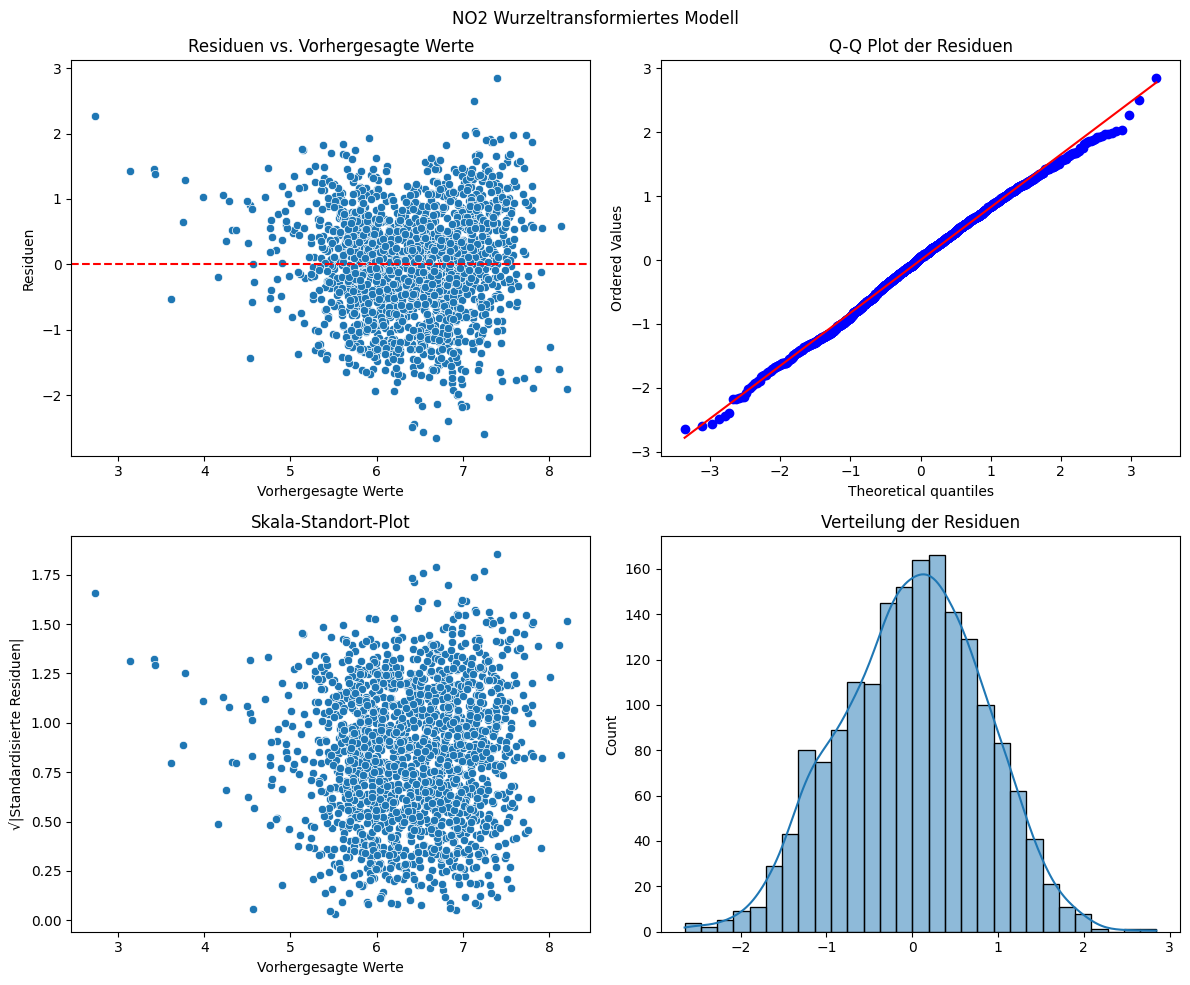


=== Shapiro-Wilk-Test der Residuen ===
PM10 Original: ShapiroResult(statistic=np.float64(0.9176054932016984), pvalue=np.float64(4.0073018947038316e-30))
PM10 Wurzel: ShapiroResult(statistic=np.float64(0.9812644635434444), pvalue=np.float64(1.580771843710961e-14))
NO2 Original: ShapiroResult(statistic=np.float64(0.9962787557031998), pvalue=np.float64(0.0002256523741514646))
NO2 Wurzel: ShapiroResult(statistic=np.float64(0.9971010027683719), pvalue=np.float64(0.002016820763372734))


In [10]:
#Punkt 5, Mostafa -> Vergleich Model mit und ohne Wurzel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats

def erstelle_modelle_mit_transformation(df, zielvariable, praediktoren):
    """Erstellt und vergleicht Modelle mit und ohne Wurzeltransformation"""
    
    # Original-Modell
    formel_original = f"{zielvariable} ~ " + " + ".join(praediktoren)
    modell_original = ols(formel_original, data=df).fit()
    
    # Modell mit Wurzeltransformation
    df[f'sqrt_{zielvariable}'] = np.sqrt(df[zielvariable])
    formel_wurzel = f"sqrt_{zielvariable} ~ " + " + ".join(praediktoren)
    modell_wurzel = ols(formel_wurzel, data=df).fit()
    
    return modell_original, modell_wurzel

def erstelle_diagnostik_plots(modell, titel):
    """Erstellt diagnostische Plots für das Modell"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuen vs. Fitted
    sns.scatterplot(x=modell.fittedvalues, y=modell.resid, ax=ax1)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Vorhergesagte Werte')
    ax1.set_ylabel('Residuen')
    ax1.set_title('Residuen vs. Vorhergesagte Werte')
    
    # Q-Q Plot
    stats.probplot(modell.resid, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot der Residuen')
    
    # Skala-Standort-Plot
    sns.scatterplot(x=modell.fittedvalues, y=np.sqrt(np.abs(modell.resid_pearson)), ax=ax3)
    ax3.set_xlabel('Vorhergesagte Werte')
    ax3.set_ylabel('√|Standardisierte Residuen|')
    ax3.set_title('Skala-Standort-Plot')
    
    # Residuen-Verteilung
    sns.histplot(modell.resid, kde=True, ax=ax4)
    ax4.set_title('Verteilung der Residuen')
    
    plt.suptitle(titel)
    plt.tight_layout()
    return fig

# Basisprädikatoren definieren
praediktoren = ['temp', 'humidity', 'prec', 'windspeed', 'peak_velocity']

# Trainingsdaten vorbereiten (2015-2019)
mask = (df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)
train_df = df_graz[mask].copy()

# Modelle für PM10
pm10_original, pm10_wurzel = erstelle_modelle_mit_transformation(train_df, 'pm10', praediktoren)

# Modelle für NO2
no2_original, no2_wurzel = erstelle_modelle_mit_transformation(train_df, 'no2', praediktoren)

# Ergebnisse ausgeben
print("=== PM10 Modellvergleich ===")
print(f"R² Original: {pm10_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {pm10_wurzel.rsquared:.3f}")
print(f"AIC Original: {pm10_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {pm10_wurzel.aic:.1f}")

print("\n=== NO2 Modellvergleich ===")
print(f"R² Original: {no2_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {no2_wurzel.rsquared:.3f}")
print(f"AIC Original: {no2_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {no2_wurzel.aic:.1f}")

# Diagnostik-Plots erstellen
diagnostik_pm10_original = erstelle_diagnostik_plots(pm10_original, "PM10 Original-Modell")
diagnostik_pm10_wurzel = erstelle_diagnostik_plots(pm10_wurzel, "PM10 Wurzeltransformiertes Modell")
diagnostik_no2_original = erstelle_diagnostik_plots(no2_original, "NO2 Original-Modell")
diagnostik_no2_wurzel = erstelle_diagnostik_plots(no2_wurzel, "NO2 Wurzeltransformiertes Modell")

plt.show()

# Shapiro-Wilk-Test für Normalität der Residuen
print("\n=== Shapiro-Wilk-Test der Residuen ===")
print("PM10 Original:", stats.shapiro(pm10_original.resid))
print("PM10 Wurzel:", stats.shapiro(pm10_wurzel.resid))
print("NO2 Original:", stats.shapiro(no2_original.resid))
print("NO2 Wurzel:", stats.shapiro(no2_wurzel.resid))